In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Import data
train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

reshape = nn.AvgPool2d(4)

# Get data parameters
N = len(train)
M = 384 * 384
Q = 96 * 96


# Set training parameters and loader
batch_size = 32
epochs = 8
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_conv_superres_diag'

In [4]:
class ConvSuperresolution(nn.Module):
    
    def __init__(self, dims, kernels, strides, pads, ae=False, **kwargs):
        super().__init__()
        self.dims = dims
        self.kernels = kernels
        self.pads = pads
        self.ae = ae
        
        self.net = modules.AdjointSequential(OrderedDict(
            V = modules.AdjointAffineConv2d(
                dims[0], dims[1], kernels[0], stride=strides[0], padding=pads[0], **kwargs
            ),
            gamma0 = modules.BiCELU(),
            W1 = modules.AdjointAffineConv2d(
                dims[1], dims[2], kernels[1], stride=strides[1], padding=pads[1], **kwargs
            ),
            gamma1 = modules.BiCELU(),
            W2 = modules.AdjointAffineConv2d(
                dims[2], dims[3], kernels[2], stride=strides[2], padding=pads[2], **kwargs
            ),
            gamma2 = modules.BiCELU(),
            W3 = modules.AdjointAffineConv2d(
                dims[3], dims[4], kernels[3], stride=strides[3], padding=pads[3], **kwargs
            ),
            gamma3 = modules.BiCELU(),
            W4 = modules.AdjointAffineConv2d(
                dims[4], dims[5], kernels[4], stride=strides[4], padding=pads[4], **kwargs
            ),
            gamma4 = modules.BiCELU(),
            D = modules.AdjointSeperableDiagonal(96, 96, **kwargs),
            U = modules.AdjointAffineConv2d(
                dims[5], dims[6], kernels[5], stride=strides[5], padding=pads[5], **kwargs
            ),
        ))
        
        self.forward = self.net.forward
        self.T = self.net.T
        
        if ae:
            self.net_bck = modules.AdjointSequential(OrderedDict(
                V = modules.AdjointAffineConv2d(
                    dims[0], dims[1], kernels[0], stride=strides[0], padding=pads[0], **kwargs
                ),
                gamma0 = modules.BiCELU(),
                W1 = modules.AdjointAffineConv2d(
                    dims[1], dims[2], kernels[1], stride=strides[1], padding=pads[1], **kwargs
                ),
                gamma1 = modules.BiCELU(),
                W2 = modules.AdjointAffineConv2d(
                    dims[2], dims[3], kernels[2], stride=strides[2], padding=pads[2], **kwargs
                ),
                gamma2 = modules.BiCELU(),
                W3 = modules.AdjointAffineConv2d(
                    dims[3], dims[4], kernels[3], stride=strides[3], padding=pads[3], **kwargs
                ),
                gamma3 = modules.BiCELU(),
                W4 = modules.AdjointAffineConv2d(
                    dims[4], dims[5], kernels[4], stride=strides[4], padding=pads[4], **kwargs
                ),
                gamma4 = modules.BiCELU(),
                D = modules.AdjointSeperableDiagonal(96, 96, **kwargs),
                U = modules.AdjointAffineConv2d(
                    dims[5], dims[6], kernels[5], stride=strides[5], padding=pads[5], **kwargs
                ),
            ))
        
            self.T = self.net_bck.T        

In [5]:
# TODO: Test with other patch dimensions for better results?
# patch_dims =    [2304, 1024, 576, 256,    9]
# grid_dims_pie = [  64,  144, 256, 576, 1024]

dims_pie = [1, 6, 12, 24, 12, 6, 1]
dims_ae =  [1, 4, 9, 16, 9, 4, 1]
kernels =  [3, 3, 5, 7, 5, 3]
strides =  [1, 2, 2, 1, 1, 1]
pads    =  [1, 1, 2, 3, 2, 1]

model_kwargs = {
    'device': device,
    'padding_mode': 'zeros',
    'transposed': True,
}

nets = {
    "PIE": ConvSuperresolution(
        dims_pie,
        kernels,
        strides,
        pads,
        **model_kwargs,
    ).to(device),
    "AE": ConvSuperresolution(
        dims_ae,
        kernels,
        strides,
        pads,
        ae = True,
        **model_kwargs,
    ).to(device),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)

In [6]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}
    
    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    kwargs = {'reduction': reduction}    
    kwargs['alpha'] = 5.0

    losses['lx'] = utils.loss.logcosh(xh, x, **kwargs)
    losses['ly'] = utils.loss.logcosh(yh, y, **kwargs)
#     losses['ls'] = 0.1 * utils.loss.logcosh(
#         splitsmall.T(yh) - reshape(split.T(x)), 
#         splitsmall.T(y) - reshape(split.T(xh)), 
#         **kwargs
#     )
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE     :  24121
No. params AE      :  24374


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k] for k in sample_indices_small])
ys = reshape(xims).to(device)[:,None,...]
xs = xims.to(device)[:,None,...]

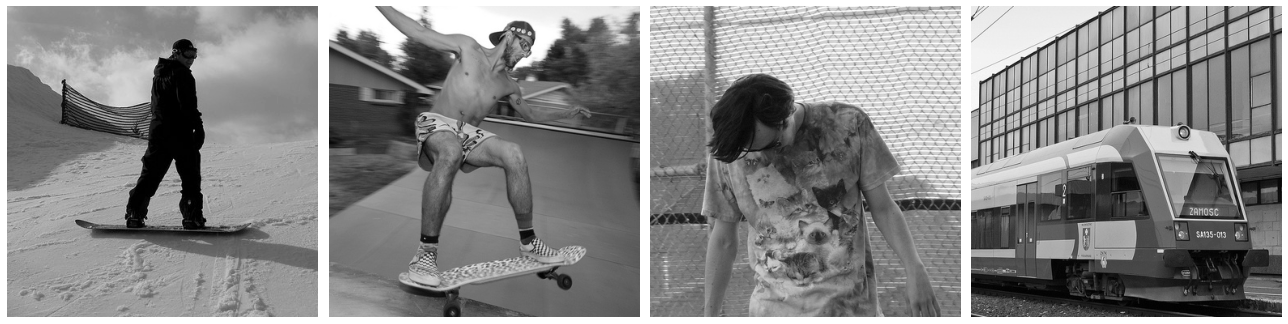

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

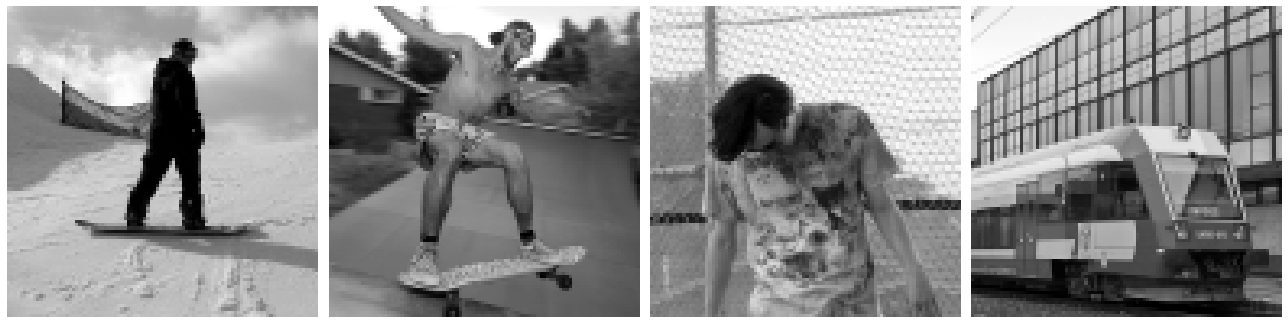

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(reshape(xims[i][None,...])[0], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

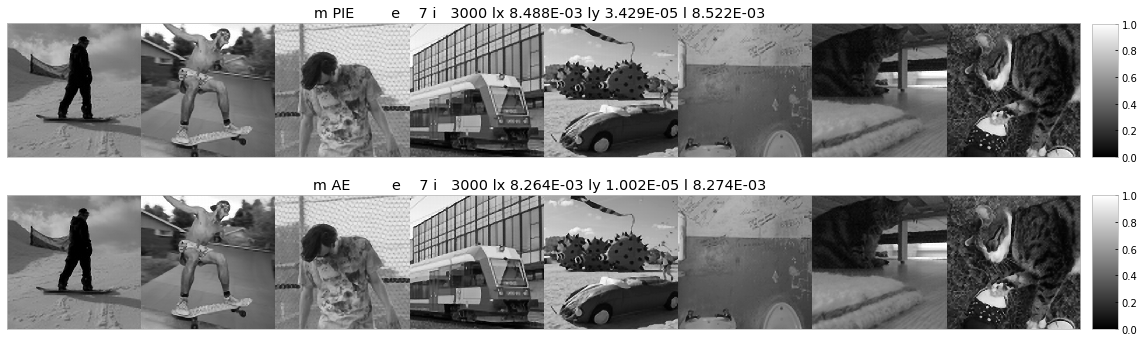

In [11]:
# Training loop

for e in range(epochs):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 25 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    xhs[cur] = nets[cur].T(ys).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, save=(i % 50 == 0), cmap='gray')
            
        i += 1

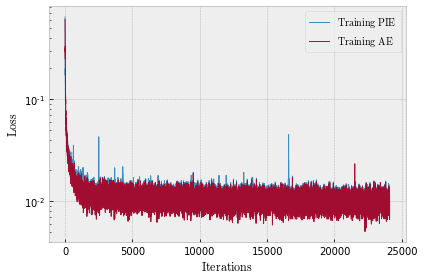

In [12]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

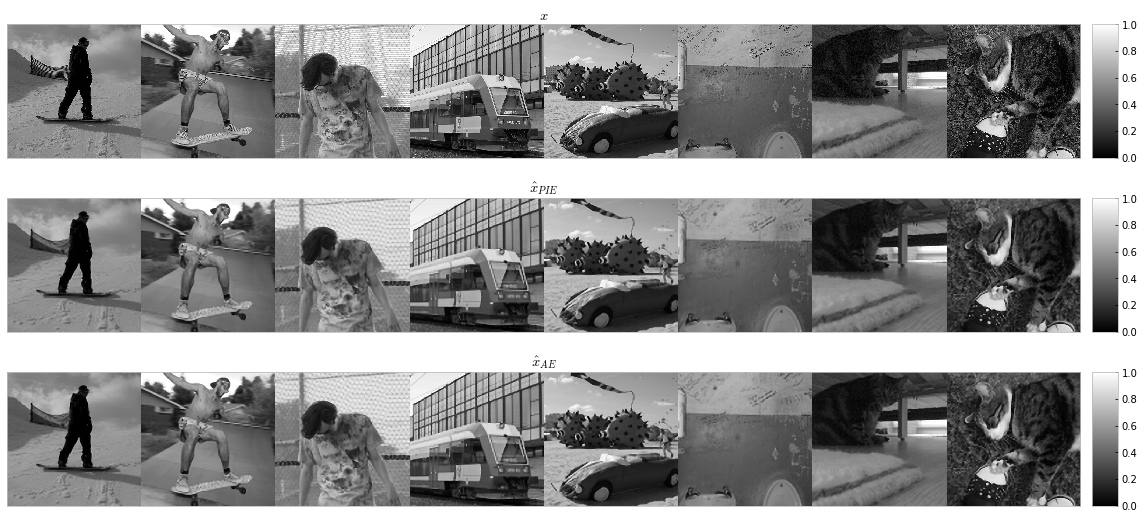

In [13]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[cur].T(ys).cpu()[:,0]
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

In [14]:
example = 6888

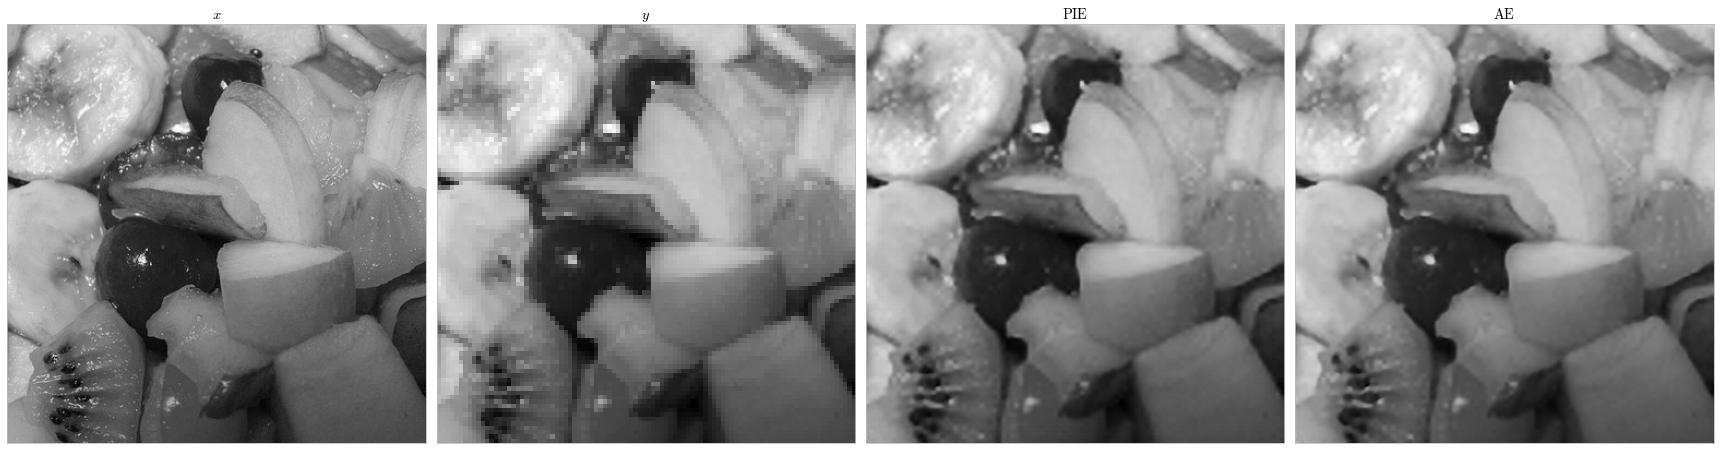

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(24,10))

ax[0].imshow(train[example][0], cmap='gray')
ax[0].set_title('$x$')
ax[1].imshow(reshape(train[example])[0], cmap='gray')
ax[1].set_title('$y$')


for i, cur in enumerate(nets):
    with torch.no_grad():
        xh = nets[cur].T(
            nets[cur](
                train[example][None,...].to(device)
            )
        )

    ax[i+2].imshow(
        xh.cpu()[0,0],
        cmap='gray'
    )
    ax[i+2].set_title(f'$\mathrm{{{cur}}}$')
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

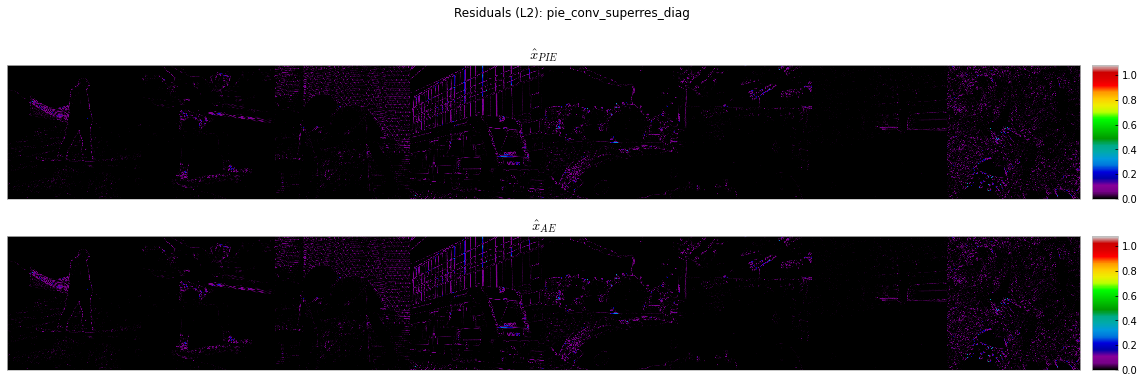

In [16]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[cur].T(ys).cpu()[:,0,...]
        xhs[k] = ((xhs[k] - xims)**2)
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [17]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [18]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [19]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [11]:
# Load Models

nets = {'PIE':None, 'AE':None}
serialized_path = f'../serialized/experiments/{experiment_name}/'
for name in nets:
    with open(f'{serialized_path}{name}.pt', 'rb') as infile:
        nets[name] = torch.load(infile)

In [21]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = torch.cat(test_tensor)[:,None,...]
test_tensor_y = reshape(test_tensor).detach()

  0%|          | 0/4002 [00:00<?, ?it/s]

In [25]:
example = 6888

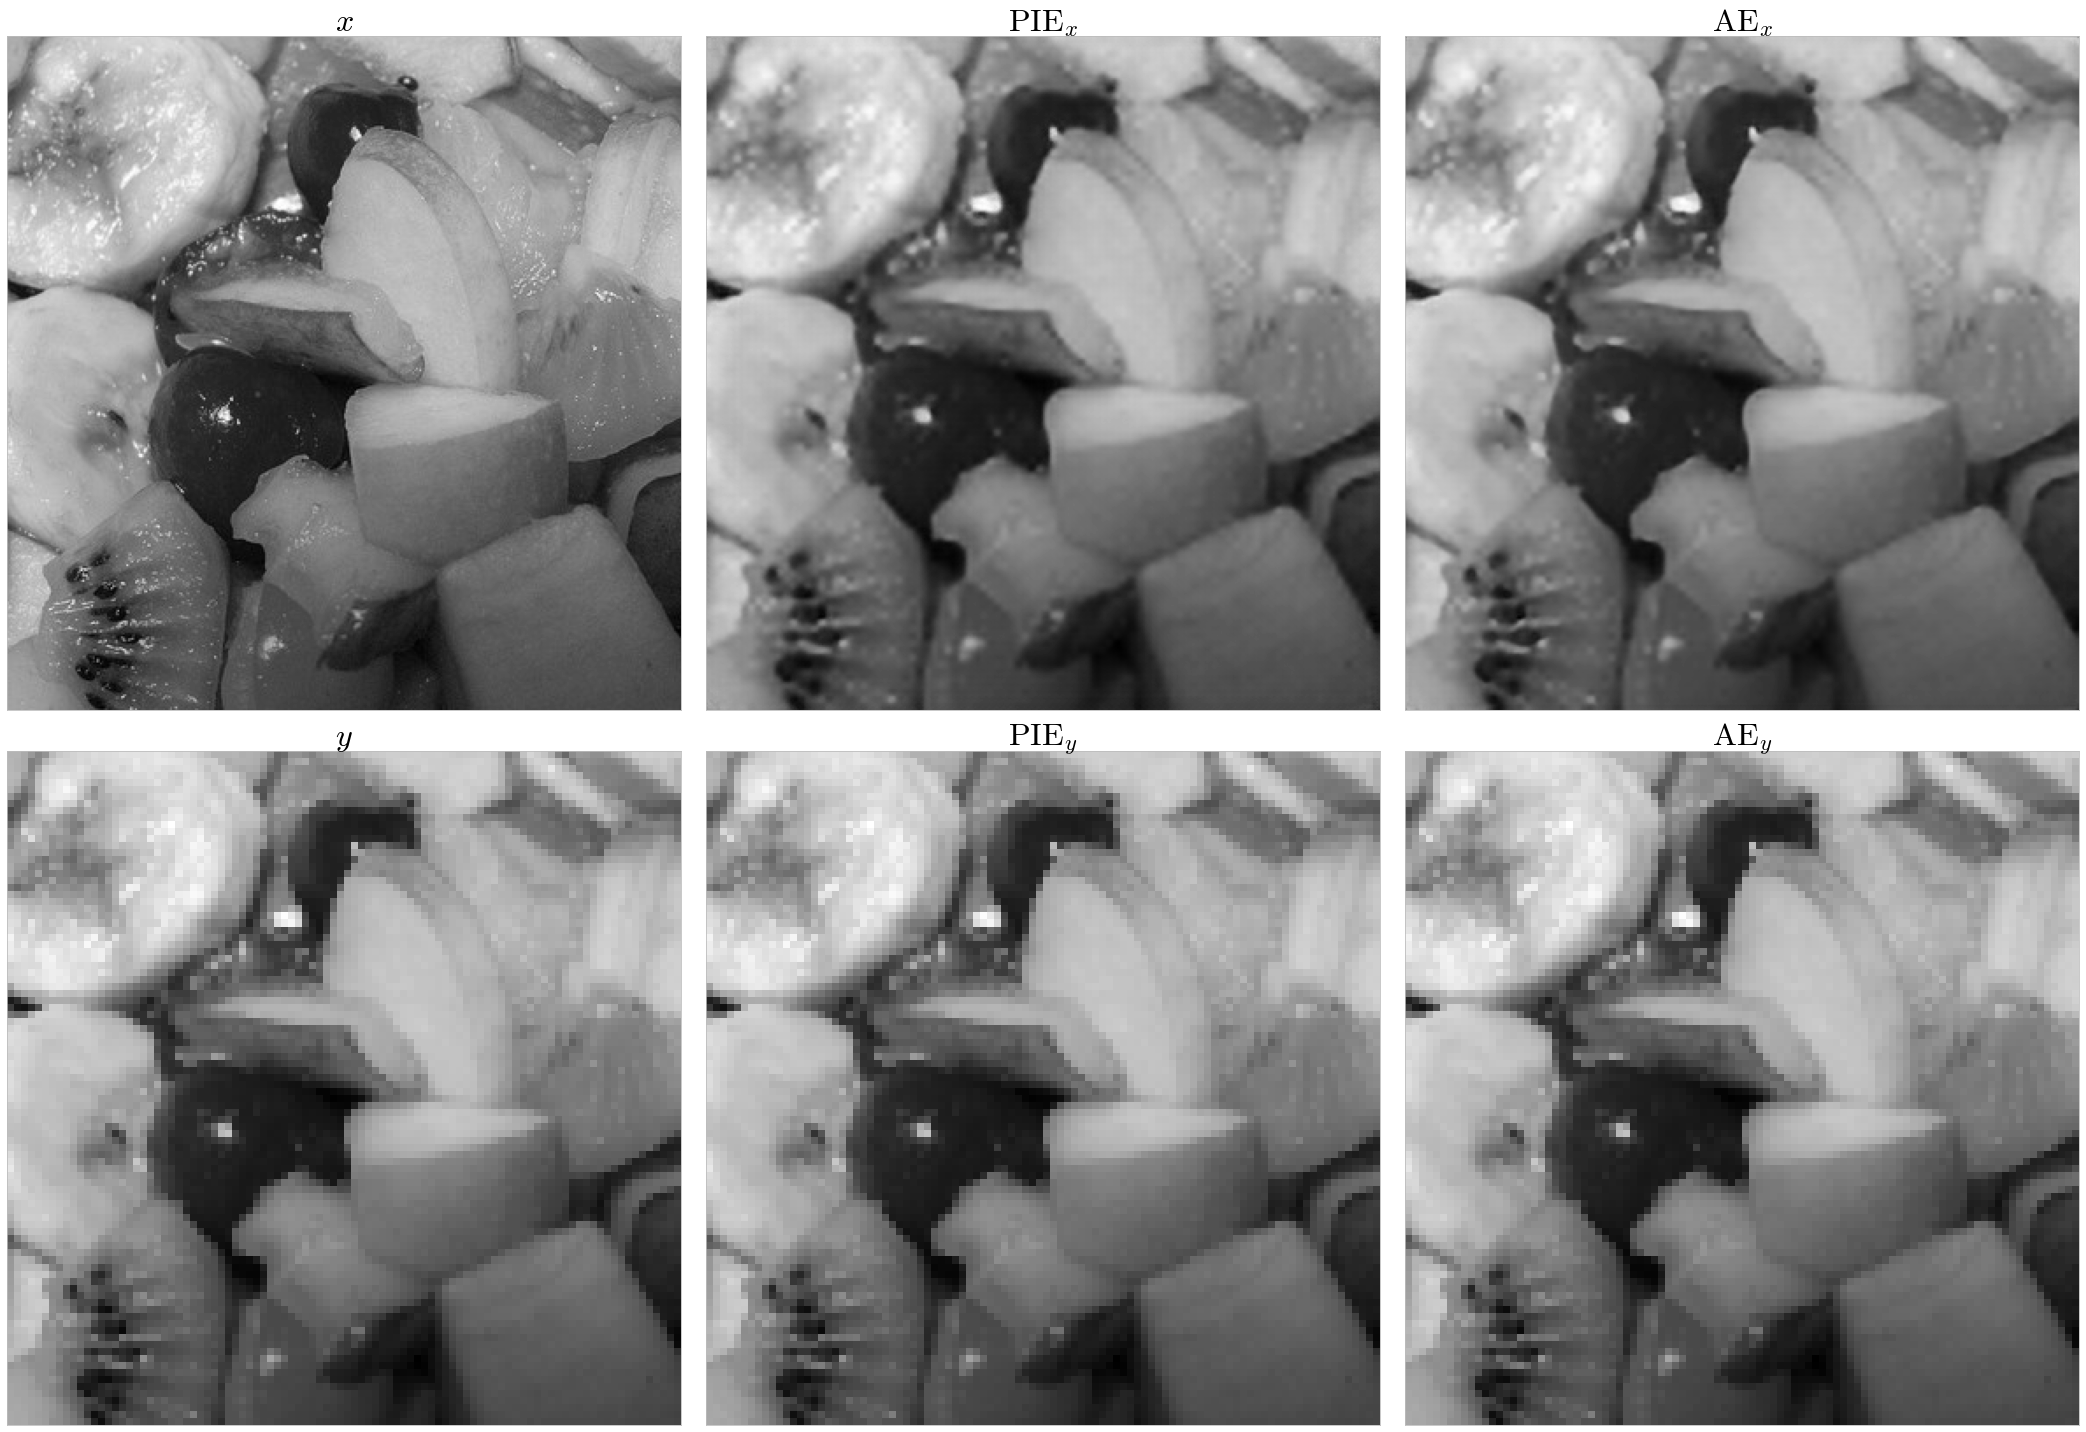

In [28]:
nets['PIE'].net.V.affine.W.resolvent = False
nets['PIE'].net.W1.affine.W.resolvent = False
nets['PIE'].net.W2.affine.W.resolvent = False
nets['PIE'].net.W3.affine.W.resolvent = False
nets['PIE'].net.W4.affine.W.resolvent = False
nets['PIE'].net.U.affine.W.resolvent = False

nets['AE'].net.V.affine.W.resolvent = False
nets['AE'].net.W1.affine.W.resolvent = False
nets['AE'].net.W2.affine.W.resolvent = False
nets['AE'].net.W3.affine.W.resolvent = False
nets['AE'].net.W4.affine.W.resolvent = False
nets['AE'].net.U.affine.W.resolvent = False

nets['AE'].net_bck.V.affine.W.resolvent = False
nets['AE'].net_bck.W1.affine.W.resolvent = False
nets['AE'].net_bck.W2.affine.W.resolvent = False
nets['AE'].net_bck.W3.affine.W.resolvent = False
nets['AE'].net_bck.W4.affine.W.resolvent = False
nets['AE'].net_bck.U.affine.W.resolvent = False

fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh = nets[cur](train[example][None,...])
        xh = nets[cur].T(reshape(train[example])[None,...])

    ax[0,i+1].imshow(
        xh.cpu()[0,0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)
    
    ax[1,i+1].imshow(
        yh.cpu()[0,0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit.pdf')

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(24,10))

ax[0].imshow(train[example][0], cmap='gray')
ax[0].set_title('$x$')
ax[1].imshow(reshape(train[example])[0], cmap='gray')
ax[1].set_title('$y$')


for i, cur in enumerate(nets):
    with torch.no_grad():
        xh = nets[cur].T(
            nets[cur](
                train[example][None,...].to(device)
            )
        )

    ax[i+2].imshow(
        xh.cpu()[0,0],
        cmap='gray'
    )
    ax[i+2].set_title(f'$\mathrm{{{cur}}}$')
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

In [22]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        xth = model.T(test_tensor_y)
        yth = model(test_tensor)
    print(
        f"{k:6}: " + 
        f"REx {utils.metrics.relative_error(xth.flatten(-3,-1), test_tensor.flatten(-3,-1), reduction='mean'):4E} " +
        f"REy {utils.metrics.relative_error(yth.flatten(-3,-1), test_tensor_y.flatten(-3,-1), reduction='mean'):4E} " +
        f"MSEx {F.mse_loss(xth.flatten(-3,-1), test_tensor.flatten(-3,-1), reduction='mean'):4E} "
        f"MSEy {F.mse_loss(yth.flatten(-3,-1), test_tensor_y.flatten(-3,-1), reduction='mean'):4E} "
    )

Relative Error:
PIE   : REx 1.320865E-01 REy 6.895514E-03 MSEx 4.852728E-03 MSEy 1.242934E-05 
AE    : REx 1.295819E-01 REy 3.727012E-03 MSEx 4.732225E-03 MSEy 3.525295E-06 


In [23]:
print(
    'PIE RE', (1.320865E-01 + 6.895514E-03) / 2,
    ' AE RE', (1.295819E-01 + 3.727012E-03) / 2,
)

PIE RE 0.069491007  AE RE 0.066654456


In [24]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        YH = model(test_tensor)
        XH = model.T(test_tensor_y)
        psnrx = utils.metrics.psnr(test_tensor.flatten(-3, -1), XH.flatten(-3, -1))
        ssimx = utils.metrics.ssim(
            test_tensor, 
            XH
        )
        psnry = utils.metrics.psnr(test_tensor_y.flatten(-3, -1), YH.flatten(-3, -1))
        ssimy = utils.metrics.ssim(
            test_tensor_y, 
            YH
        )
    print(
        f"{k:6}: " + 
        f"PSNRx {psnrx:4E} " +
        f"PSNRy {psnry:4E} " +
        f"SSIMx {ssimx:4E} " +
        f"SSIMy {ssimy:4E} "
    )

Image Reconstruction Metrics:
PIE   : PSNRx 2.314014E+01 PSNRy 4.905552E+01 SSIMx 7.013123E-01 SSIMy 9.991338E-01 
AE    : PSNRx 2.324935E+01 PSNRy 5.452805E+01 SSIMx 7.087123E-01 SSIMy 9.997791E-01 


NameError: name 'gc' is not defined

In [26]:
print(
    'PIE PSNR', (2.314014E+01 + 4.905552E+01) / 2,
    ' AE PSNR', (2.324935E+01 + 5.452805E+01) / 2,
)

PIE PSNR 36.09783  AE PSNR 38.8887


In [18]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(1, 384, 384).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [21]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    lphiy = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

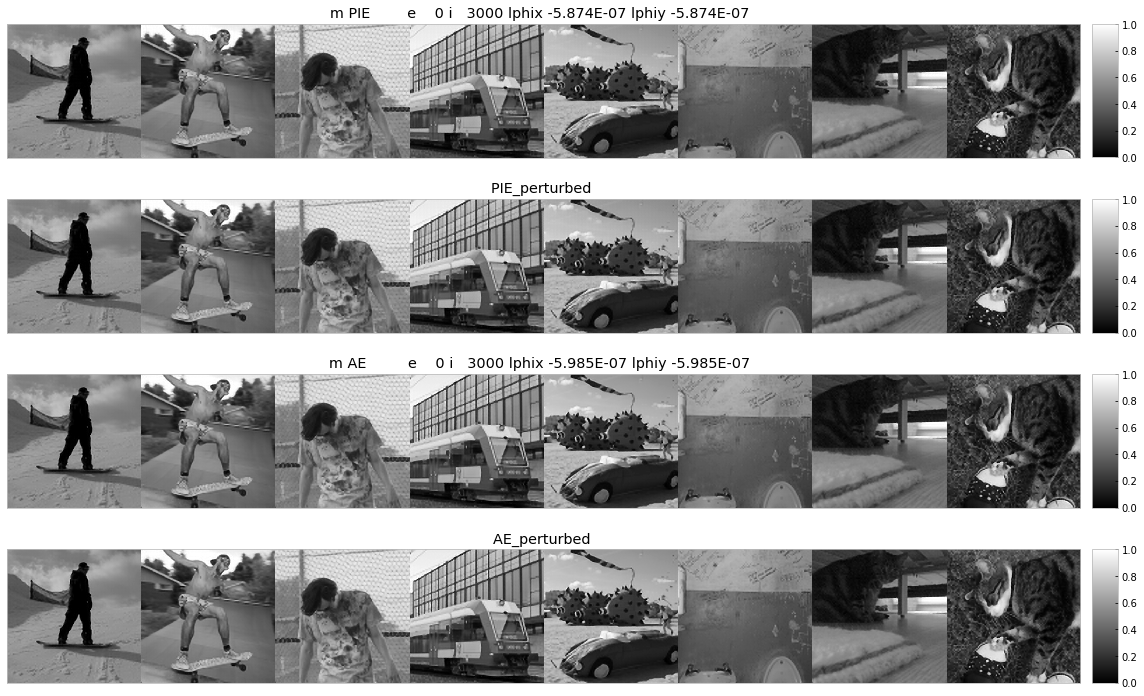

In [28]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1,384, 384))

            xh = nets[cur].T(nets[cur](x))
            xe = nets[cur].T(nets[cur](x + r))

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 384, 384))

                    xhs[cur] = nets[cur].T(nets[cur](xs)).cpu()[:,0,...]
                    xhs[per] = nets[cur].T(nets[cur](xs + r)).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

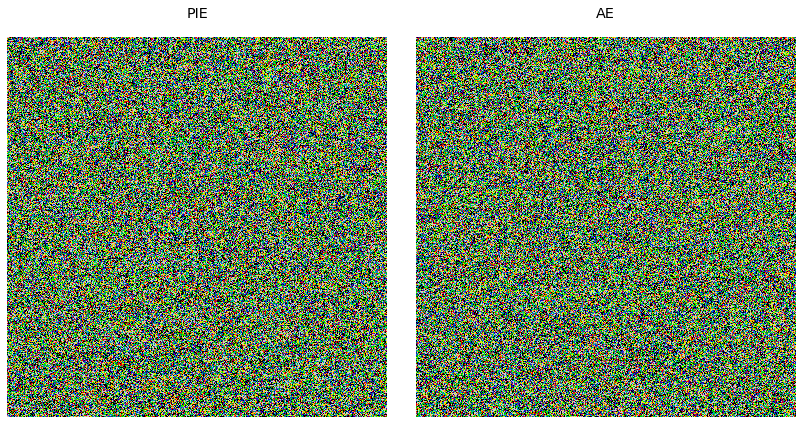

In [30]:
fig, ax = plt.subplots(1, 2)
for i, (k, r) in enumerate(rs.items()):
    ax[i].matshow(
        r[0,...].to('cpu').detach(), 
        vmin=-1, 
        vmax=1
    )
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [ ]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = torch.cat(test_tensor)[:,None,...]
test_tensor_y = reshape(test_tensor).detach()

In [32]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].flatten(-3, -1), 1, 2).unflatten(-1, (1,384, 384)).cpu()
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH.flatten(-3,-1), XE.flatten(-3,-1), reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor.flatten(-3,-1), (test_tensor + r).flatten(-3,-1), reduction='mean')
    cond_no = utils.metrics.relative_cond_no(
        XH.flatten(-3,-1), 
        XE.flatten(-3,-1), 
        test_tensor.flatten(-3,-1), 
        r.flatten(-3,-1), 
        reduction='mean'
    )
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.001599 0.005357 0.052944
AE    : 0.001610 0.005357 0.053311


In [17]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(1, 96, 96).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [18]:
for k in nets:
    for V in nets[k].net:
        if isinstance(V, modules.AdjointAffineConv2d):
            V.affine.W.resolvent = False
    if k == 'AE':
        for V in nets[k].net_bck:
            if isinstance(V, modules.AdjointAffineConv2d):
                V.affine.W.resolvent = False
                
                
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    lphiy = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

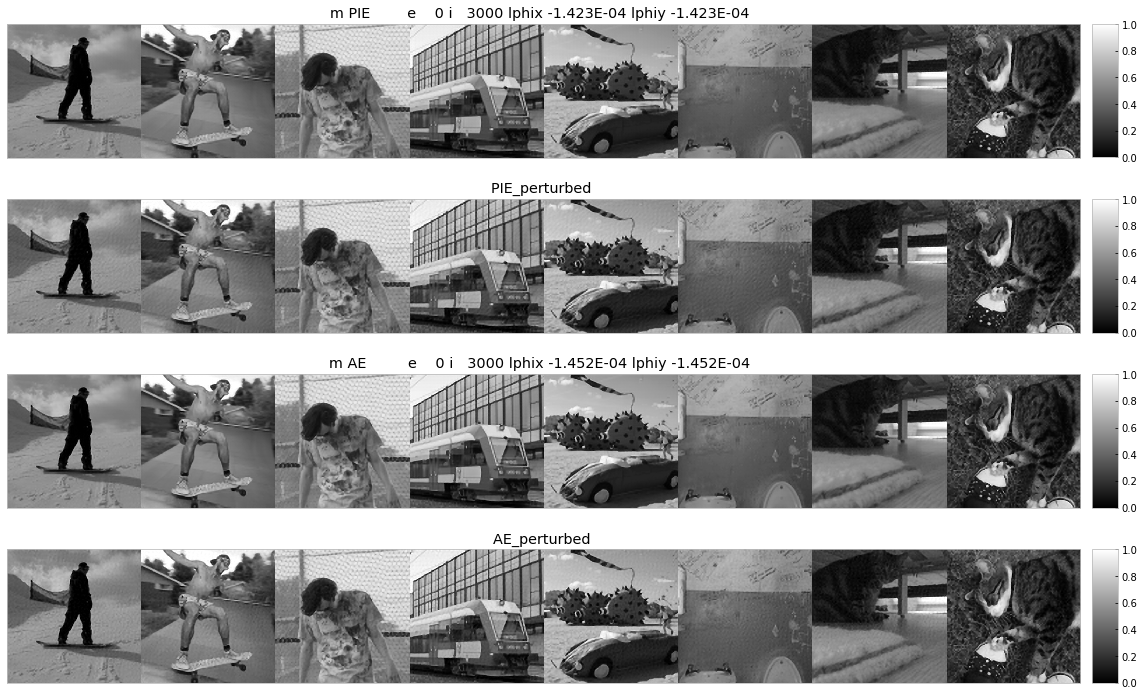

In [19]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 96, 96))

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 96, 96))

                    xhs[cur] = nets[cur].T(nets[cur](xs)).cpu()[:,0,...]
                    xhs[per] = nets[cur].T(nets[cur](xs) + r).cpu()[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [22]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")
for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 96, 96)).cpu()
        XE = model.T(test_tensor_y + r)
        XH = model.T(test_tensor_y)

    cond_no = utils.metrics.relative_cond_no(
        XH.flatten(-3,-1), 
        XE.flatten(-3,-1), 
        test_tensor_y.flatten(-3,-1), 
        r.flatten(-3,-1), 
        reduction='mean'
    )
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.794083
AE    : 0.812582
